## ON THE PLURALITY OF GRAPHS

Small _network-based_ playground to create sample graphs on which to play Lewis signaling games ;-)

### Installation and imports

_First make sure we have networkx updated as v 2.0 had some API changes and we want to avoid troubles_

In [1]:
# ! pip install networkx --upgrade

_Install also the nice powerlaw package if we want to run also the power law analysis_

In [2]:
# ! pip install powerlaw

In [1]:
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from scipy.special import softmax
from collections import Counter
import math

In [2]:
%matplotlib inline

### Simulation variables

In [3]:
N_NODES = 16
NETWORK_PARAMS = dict()

Settings for barabasi-albert graph - scale free with pref attachment

https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html?highlight=barabasi_albert_graph#networkx.generators.random_graphs.barabasi_albert_graph

In [4]:
NETWORK_PARAMS['barabasi'] = [N_NODES, 5] 

Settings for Erdős–Rényi model - random graph

https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html?highlight=erdos_renyi_graph#networkx.generators.random_graphs.erdos_renyi_graph

In [5]:
NETWORK_PARAMS['erdos'] = [N_NODES, 0.15]

Settings for the Watts–Strogatz - "small-world graph", including short average path lengths and high clustering (six-degrees of separation kind of thing) 

https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html?highlight=watts_strogatz_graph#networkx.generators.random_graphs.watts_strogatz_graph

In [6]:
NETWORK_PARAMS['watts'] = [N_NODES, 3, 0.1]

### Some graph / chart / stats utils functions

In [7]:
def draw_network(nx_graph, node_color='black', node_size=100, width=3):
    options = {
        'node_color': node_color,
        'node_size': node_size,
        'width': width
    }
    nx.draw(nx_graph, with_labels=True, font_weight='bold', **options)
    plt.show()

In [8]:
def get_all_degrees(nx_graph):
    return [d for n, d in nx_graph.degree()]

In [9]:
def plot_distribution(nx_graph, bins=20, label='My Graph'):
    """
    Convenient function that retrieves all degree and bins them to visualize distribution
    """ 
    all_degrees = get_all_degrees(nx_graph)
    plt.hist(all_degrees, bins=bins)
    plt.title("Frequency Distribution for {}".format(label))
    plt.show()

In [10]:
def fit_power_law_to_data(data, alternative_distribution='lognormal', target_file=None):
    """
    Use fantastic powerlaw package based on SFI paper -> https://arxiv.org/pdf/1305.0215.pdf
    """
    # fit a discrete powerlaw here
    results = powerlaw.Fit(data, discrete=True)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p = results.distribution_compare('power_law', alternative_distribution, normalized_ratio=True)
    fig2 = results.plot_ccdf(color='b', linewidth=2)
    results.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    # save to disk if a path is specified
    if target_file:
        fig2.figure.savefig(target_file)
    
    return alpha, xmin, R, p, results.truncated_power_law.alpha

### Interlude: Test out networkx general functions

First, test out networkx generation capabilities on two types of graphs

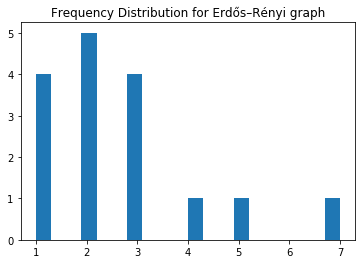

In [11]:
# generate graph with params
er = nx.erdos_renyi_graph(*NETWORK_PARAMS['erdos'])
# plot distribution
plot_distribution(er, bins=20, label='Erdős–Rényi graph')

55


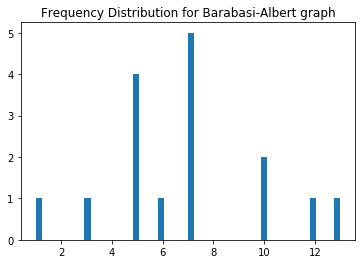

In [12]:
# generate graph with params
ba = nx.barabasi_albert_graph(*NETWORK_PARAMS['barabasi'])
print(ba.number_of_edges())
# plot distribution
plot_distribution(ba, bins=50, label='Barabasi-Albert graph')
# fit a powerlaw

_Check degree distribution using the nice powerlaw package from http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0085777_

Calculating best minimal value for power law fit
/home/nicole/anaconda3/envs/torch/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


ZeroDivisionError: 

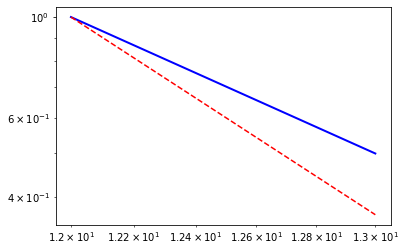

In [13]:
# check goodness of fit against a natural candidate -> see https://arxiv.org/pdf/1305.0215.pdf
alternative_distribution = 'exponential'
alpha, xmin, R, p, t_alpha = fit_power_law_to_data(get_all_degrees(ba), alternative_distribution=alternative_distribution)
print("Alpha value for p-law: {}".format(alpha))
print("Loglikelihood ratio between the two candidate distributions is {}, favoring {}".format(R,
                                                                                             'powerlaw' if R > 0.0 else alternative_distribution))
print("The significance value for the ratio is {}".format(p))

_As expected, the BA network is well-represented by the power-law distribution for degrees_

Finally, not exactly fancy, but try to draw a small graph in case we need some charts later on...

/home/nicole/anaconda3/envs/torch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


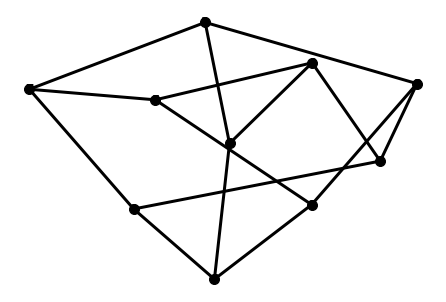

In [14]:
g = nx.petersen_graph()
draw_network(g)

### Generating networks and sampling strategies

In [15]:
def pick_random_nodes(nodes, n=1, weights=None):
    """
    Return N nodes, if weights is specified choose the nodes with proportional probabilities
    """
    # probabilities needs to sum up to 1...
    probs = softmax(weights) if weights else None
    return np.random.choice(nodes, n, p=probs)

In [16]:
def get_network_by_type_and_settings(network_type, network_settings):
    """
    Network type must be one of: erdos, watts, barabasi
    """
    if network_type == 'erdos':
        return nx.erdos_renyi_graph(*network_settings)
    elif network_type == 'watts':
        return nx.connected_watts_strogatz_graph(*network_settings)
    elif network_type == 'barabasi':
        return nx.barabasi_albert_graph(*network_settings)
    else:
        raise Exception("Unknown type: {}".format(network_type))

In [17]:
def calculate_network_centrality(nx_graph, centrality_metrics):
    """
    centrality_metrics must be one of 'degree', 'pagerank', 'betweeness'
    
    return type is always a dict(node->measure of centrality)
    """
    if centrality_metrics == 'degree':
        return nx.degree_centrality(nx_graph)
    elif centrality_metrics == 'betweeness':
        return nx.betweenness_centrality(nx_graph)
    elif centrality_metrics == 'pagerank':
        return nx.pagerank_numpy(nx_graph)
    else:
        raise Exception("Unknown metrics: {}".format(centrality_metrics))

In [18]:
# list options
NETWORK_TOPOLOGIES = ['erdos', 'watts', 'barabasi']
# pick one randomly here
current_topology = choice(NETWORK_TOPOLOGIES)
# list options
CENTRALITY_MEASURES = ['degree', 'pagerank', 'betweeness']
# pick one randomly here
current_centrality_measure = choice(CENTRALITY_MEASURES)
print("Chosen topology is: {}, with params: {} and centrality: {}".format(current_topology, 
                                                                          NETWORK_PARAMS[current_topology],
                                                                          current_centrality_measure))

Chosen topology is: watts, with params: [16, 3, 0.1] and centrality: pagerank


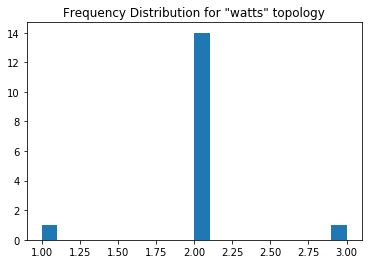

0 0.058038540603673576
1 0.058707759513122494
2 0.058038540603673465
3 0.04014239767282162
4 0.07239387687722705
5 0.0679949149537147
6 0.06553533477857211
7 0.06414704923116098
8 0.06334007517710072
9 0.06282959824437002


In [19]:
# generate network
current_network = get_network_by_type_and_settings(current_topology, NETWORK_PARAMS[current_topology])
# plot distribution
plot_distribution(current_network, bins=20, label='"{}" topology'.format(current_topology))
# get centrality
node_2_centrality = calculate_network_centrality(current_network, current_centrality_measure)
# print out some sample centrality values for debug
for n in list(node_2_centrality.keys())[:10]:
    print(n, node_2_centrality[n])

In [20]:
len(current_network.edges)

16

In [21]:
def sample_neighbors_of_node(nx_graph, source_node, topn=1):
    """
    Get neighboring nodes and then return N random ones up until the topn
    """
    neighbors = [n for n in nx_graph.neighbors(source_node)]
    # we shouldn't have disconnected graphs, but check to avoid weird things..
    assert len(neighbors) > 0
    
    # check N are not less than the requested amount
    if topn >= len(neighbors):
        return neighbors
    
    # return random subset
    return np.random.choice(neighbors, topn, replace=False)

In [22]:
def sample_pair_randomly(nx_graph, verbose=False):
    first_node = pick_random_nodes(list(nx_graph.nodes))[0]
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    if verbose:
        print("Sampled {} and {}".format(first_node, second_node))
    
    return (first_node, second_node)

# just run it once
sample_pair_randomly(current_network)

(9, 10)

In [23]:
def sample_pair_through_centrality(nx_graph, node_2_centrality):
    # node_2_centrality is a dict of node ids mapping to the node's centrality
    # think about passing directly the node list if we need to do it a lot...

    node_list = list(nx_graph.nodes)

    weights = [node_2_centrality[n] for n in node_list]
    first_node = pick_random_nodes(node_list, n=1, weights=weights)[0]
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    
    return (first_node, second_node)

# just run it once
sample_pair_through_centrality(current_network, node_2_centrality)

(11, 10)

_As a numerical test run 1000 times the centrality one for two networks and check how distributions get skewed..._

In [24]:
for test_network_type in ['barabasi', 'erdos']:
    test_network = get_network_by_type_and_settings(test_network_type, NETWORK_PARAMS[test_network_type])
    test_node_2_centrality = calculate_network_centrality(test_network, 'pagerank')  # compute centrality measure for each node in network
    # run the sampling 100 times...
    sampled_pairs = [sample_pair_through_centrality(test_network, test_node_2_centrality) for _ in range(1000)]
    # flatten the pairs and count them 
    cnt_nodes = Counter([item for sublist in sampled_pairs for item in sublist])
    print("\n{} most sampled pairs:".format(test_network_type))
    print(cnt_nodes.most_common(10))


barabasi most sampled pairs:
[(5, 239), (4, 165), (6, 160), (8, 156), (7, 147), (9, 142), (10, 134), (14, 122), (11, 118), (12, 103)]


AssertionError: 

In [25]:
test_network = get_network_by_type_and_settings("barabasi", NETWORK_PARAMS["barabasi"])
test_node_2_centrality = calculate_network_centrality(test_network, "pagerank")

In [26]:
sampled_pairs = sample_pair_through_centrality(test_network, test_node_2_centrality)

In [27]:
sampled_pairs

(8, 7)

_Now test the sampling function always returns data as expected running them with different configs and network_

In [28]:
TEST_SIZE = 10
for n_t in NETWORK_TOPOLOGIES:
    for c_m in CENTRALITY_MEASURES:
        print(n_t, c_m)
        c_network = get_network_by_type_and_settings(n_t, NETWORK_PARAMS[n_t])
        n_2_centrality = calculate_network_centrality(c_network, c_m)
        for _ in range(TEST_SIZE):
            # half the time, sample with centrality, half the time randomly
            if _ % 2 == 0:
                s_pair = sample_pair_through_centrality(c_network, n_2_centrality)
            else:
                s_pair = sample_pair_randomly(c_network)
            # check we have results
            assert len(s_pair) == 2 and all(s is not None for s in s_pair)

erdos degree
erdos pagerank
erdos betweeness


AssertionError: 

Finally show how to apply the "Friendship paradox" to sample highly central individuals without assuming a bird-eye of the entire network and all the centrality values..

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2939797/ 
    
https://en.wikipedia.org/wiki/Friendship_paradox

In [29]:
def sample_pair_through_friends(nx_graph):
    # sample a pair of nodes first 
    first_node, second_node = sample_pair_randomly(nx_graph)
    # we discard the first one, and consider its friend - the second one - as the new first one
    friend_node = sample_neighbors_of_node(nx_graph, second_node)[0]
    
    return (second_node, friend_node)

# just run it once
sample_pair_through_friends(current_network)

(12, 13)

_Finally test if the centrality is actually better than random..._

In [30]:
test_network = get_network_by_type_and_settings('barabasi', NETWORK_PARAMS['barabasi'])
test_node_2_centrality = calculate_network_centrality(test_network, 'betweeness')
N = 10
# run the sampling 10 times... with pure random vs friend sampling
sampled_pairs = [sample_pair_randomly(test_network) for _ in range(N)]
print(sampled_pairs)
# flatten the pairs and map them to centrality
total_centrality = sum([test_node_2_centrality[i] for i in [item for sublist in sampled_pairs for item in sublist]])
print("Total centrality random: {}\n".format(total_centrality))
# now do the same with friend sampling
sampled_pairs = [sample_pair_through_friends(test_network) for _ in range(N)]
# flatten the pairs and map them to centrality
total_centrality = sum([test_node_2_centrality[i] for i in [item for sublist in sampled_pairs for item in sublist]])
print("Total centrality with friends: {}".format(total_centrality))

[(1, 6), (9, 3), (8, 3), (5, 15), (12, 7), (10, 12), (12, 10), (1, 6), (5, 9), (5, 15)]
Total centrality random: 1.2475056689342403

Total centrality with friends: 0.7691836734693879


### Test edge cardinality

For the 'watts' topology, number of edges depends only on the K value (the second param). If k is even,
n of edges will be = N of nodes * k / 2

In [31]:
c_network = get_network_by_type_and_settings('watts', [N_NODES, 6, 0.5])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 4, 0.2])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 6, 0.2])
print(c_network.number_of_edges())
c_network = get_network_by_type_and_settings('watts', [N_NODES, 4, 0.5])
print(c_network.number_of_edges())

48
32
48
32


In [32]:
for _ in range (2, 20, 2):
    c_network = get_network_by_type_and_settings('watts', [N_NODES, _, 0.1])
    print(_, c_network.number_of_edges())

2 16
4 32
6 48
8 64
10 80
12 96
14 112


NetworkXError: k>=n, choose smaller k or larger n

In [33]:
# sample function allowing to control for edge number instead than k
def create_watts_with_nodes_and_edges(n_nodes, n_edges, rewriting_prob=0.15):
    k = int((n_edges * 2) / n_nodes)
    return k, nx.connected_watts_strogatz_graph(n=n_nodes, k=k, p=rewriting_prob)

for _ in range (1000, 10000, 1000):
    k, c_network = create_watts_with_nodes_and_edges(N_NODES, _)
    assert _ == c_network.number_of_edges()

NetworkXError: k>=n, choose smaller k or larger n

For random networks, the number of edges is proportional to the probability of each link being drawn (links are statistically independent and are controlled by the only free params _p_ in the constructor). Considering undirected graphs, the number of pairs is nodes^2 / 2 (to remove same pairs with different ordering) - so the "expected" edge number will be equal to = PAIRS * p 


In [34]:
for _ in range (1, 9):
    c_network = get_network_by_type_and_settings('erdos', [N_NODES, _ / 10])
    # check numbers
    print(_ / 10, c_network.number_of_edges(), ((N_NODES * N_NODES) / 2)  * _ / 10)

0.1 9 12.8
0.2 26 25.6
0.3 37 38.4
0.4 45 51.2
0.5 66 64.0
0.6 66 76.8
0.7 93 89.6
0.8 107 102.4


In [35]:
# sample function allowing to control for edge number
def create_erdos_with_nodes_and_edges(n_nodes, n_edges):
    p = n_edges / ((n_nodes * n_nodes) / 2)
    c_network = get_network_by_type_and_settings('erdos', [n_nodes, p])
    # debug
    # print(p, n_edges, c_network.number_of_edges())
    return p, c_network

for _ in range (1000, 10000, 1000):
    p, c_network = create_erdos_with_nodes_and_edges(N_NODES, _)
    assert abs(_ - c_network.number_of_edges()) < (_ * 0.05)

AssertionError: 

The barabasi network is grown up to N by attaching new nodes each with M edges that are preferentially attached to existing nodes with high degree, generating the characteristic distribution. Number of edges is -> N * m, minus correction for the first K node for which we cannot generate all the edges.

In [36]:
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 5])
print(c_network.number_of_edges(), N_NODES * 5 * pow(5, 2))
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 10])
print(c_network.number_of_edges(), N_NODES * 10 * pow(10, 2))
c_network = get_network_by_type_and_settings('barabasi', [N_NODES, 65])
print(c_network.number_of_edges(), N_NODES * 65 * pow(65, 2))

55 2000
60 16000


NetworkXError: Barabási–Albert network must have m >= 1 and m < n, m = 65, n = 16

Given the nature of the relation, two values may generate same N of edges, with VERY different distribution - as for example 5 and 995

55


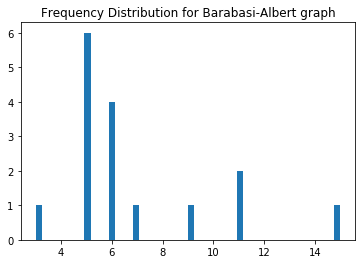

NetworkXError: Barabási–Albert network must have m >= 1 and m < n, m = 995, n = 16

In [37]:
for _ in [(5, 995), (10, 990)]:
    ba = nx.barabasi_albert_graph(N_NODES, _[0])
    print(ba.number_of_edges())
    plot_distribution(ba, bins=50, label='Barabasi-Albert graph')
    ba = nx.barabasi_albert_graph(N_NODES, _[1])
    print(ba.number_of_edges())
    plot_distribution(ba, bins=50, label='Barabasi-Albert graph')

In [38]:
def solve_poly(a, b, c):
    # ax**2 + bx + c = 0
    # calculate the discriminant
    d = (b**2) - (4*a*c)
    # return two solutions
    return (-b - math.sqrt(d))/(2*a), (-b + math.sqrt(d))/(2*a)

# debug
a = 1
b = -1000
c = 4975
solve_poly(1, -1000, 4975)

(5.0, 995.0)

In [39]:
# sample function allowing to control for edge number
def create_barabasi_with_nodes_and_edges(n_nodes, n_edges):
    solutions = solve_poly(1, n_nodes * -1.0, n_edges)
    m = int(min(solutions))
    c_network = get_network_by_type_and_settings('barabasi', [n_nodes, m])
    # debug
    print(m, n_edges, c_network.number_of_edges(), solutions)
    return m, c_network

for _ in range (1000, 10000, 1000):
    m, c_network = create_barabasi_with_nodes_and_edges(N_NODES, _)
    assert abs(_ - c_network.number_of_edges()) < (_ * 0.05)

for _ in range (100, 1000, 100):
    m, c_network = create_barabasi_with_nodes_and_edges(100, _)
    assert abs(_ - c_network.number_of_edges()) < (_ * 0.10)

ValueError: math domain error

#### Run some test and check the generated networks with the final values for paper

In [40]:
PAPER_N_NODES = 16
PAPER_N_EDGES = 32

In [41]:
m, b_network = create_barabasi_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)

2 32 28 (2.3431457505076194, 13.65685424949238)


In [42]:
centrality = calculate_network_centrality(b_network, "pagerank")

In [43]:
type(list(b_network.nodes)[0])

int

In [44]:
pairs = [sample_pair_through_centrality(b_network, centrality) for _ in range(32)]

In [45]:
g = nx.empty_graph()
g.add_nodes_from(range(PAPER_N_NODES))
g.add_edges_from(pairs)

In [46]:
g.edges

EdgeView([(1, 5), (1, 13), (1, 7), (1, 3), (2, 7), (2, 3), (2, 4), (2, 12), (3, 6), (3, 9), (3, 11), (3, 5), (3, 10), (3, 15), (4, 14), (5, 11), (6, 14), (8, 13), (8, 15), (9, 10)])

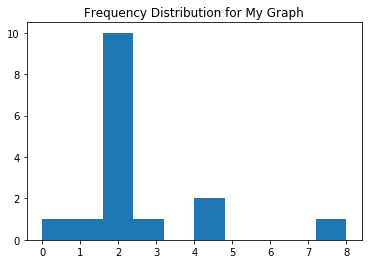

In [47]:
plot_distribution(g, bins=10)

In [48]:
get_all_degrees(g)

[0, 4, 4, 8, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2]

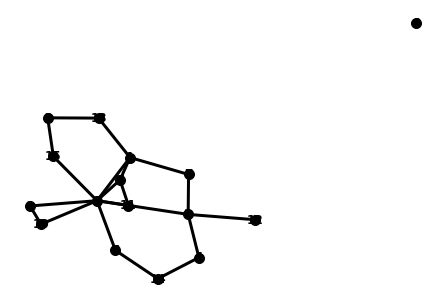

In [49]:
draw_network(g)

8 64 64 (8.0, 8.0)
8 64


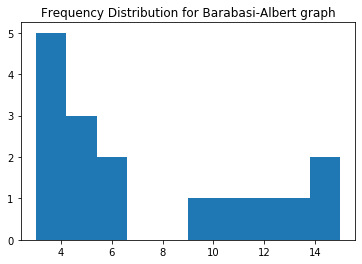

0.5 60


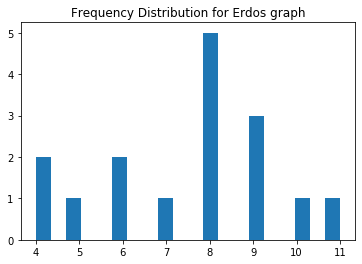

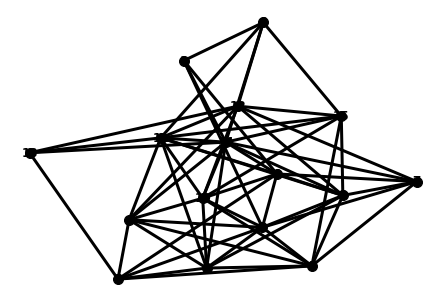

8 64


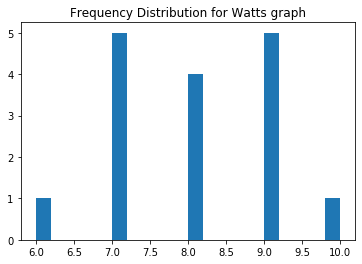

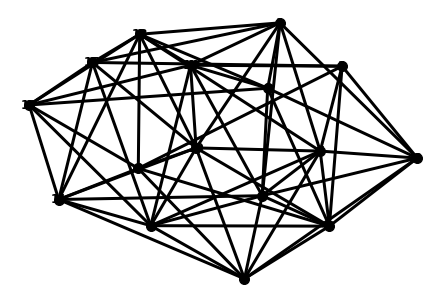

In [53]:
m, b_network = create_barabasi_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(m, b_network.number_of_edges())
plot_distribution(c_network, bins=10, label='Barabasi-Albert graph')
p, e_network = create_erdos_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(p, e_network.number_of_edges())
plot_distribution(e_network, bins=20, label='Erdos graph')
draw_network(e_network)
k, w_network = create_watts_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(k, w_network.number_of_edges())
plot_distribution(w_network, bins=20, label='Watts graph')
draw_network(w_network)

In [55]:
centrality = calculate_network_centrality(w_network, "pagerank")

In [56]:
pairs = [sample_pair_through_centrality(w_network, centrality) for _ in range(64)]

In [57]:
pairs

[(2, 5),
 (7, 10),
 (7, 4),
 (12, 8),
 (15, 1),
 (0, 4),
 (11, 10),
 (2, 14),
 (10, 7),
 (5, 7),
 (13, 0),
 (13, 14),
 (15, 11),
 (2, 5),
 (0, 6),
 (1, 4),
 (6, 3),
 (10, 9),
 (11, 8),
 (0, 6),
 (12, 11),
 (5, 10),
 (13, 9),
 (14, 4),
 (2, 3),
 (4, 8),
 (14, 10),
 (4, 1),
 (6, 8),
 (3, 7),
 (2, 14),
 (2, 15),
 (2, 15),
 (5, 8),
 (0, 12),
 (0, 6),
 (5, 7),
 (4, 6),
 (2, 15),
 (12, 13),
 (11, 4),
 (13, 11),
 (10, 14),
 (11, 4),
 (5, 7),
 (11, 9),
 (13, 10),
 (14, 2),
 (15, 8),
 (4, 6),
 (4, 3),
 (9, 6),
 (10, 14),
 (6, 3),
 (3, 7),
 (10, 13),
 (8, 5),
 (0, 6),
 (6, 4),
 (14, 12),
 (3, 5),
 (12, 15),
 (5, 8),
 (14, 4)]

In [54]:
PAPER_N_NODES = 16
PAPER_N_EDGES = 64

In [52]:
m, network = create_barabasi_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)

8 64 64 (8.0, 8.0)


In [71]:
len(network.edges)

64

In [72]:
network.edges

EdgeView([(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 14), (1, 8), (1, 14), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 8), (3, 9), (3, 10), (3, 12), (3, 13), (3, 14), (4, 8), (4, 9), (4, 13), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 9), (6, 10), (6, 11), (6, 13), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 10), (9, 11), (9, 12), (9, 14), (9, 15), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 12), (11, 13), (11, 14), (12, 13), (12, 15), (13, 15), (14, 15)])

In [73]:
s

NameError: name 's' is not defined

8 64 64 (8.0, 8.0)
8 64


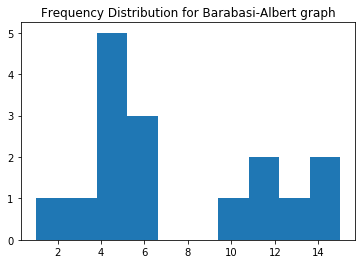

0.5 65


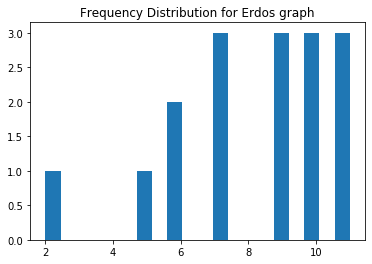

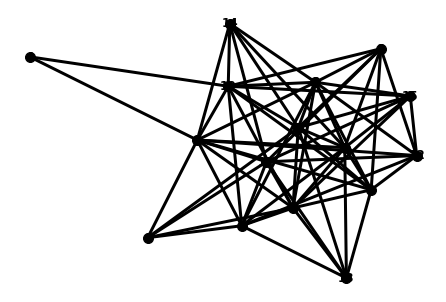

8 64


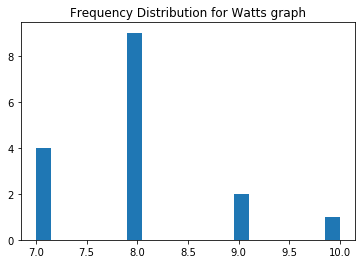

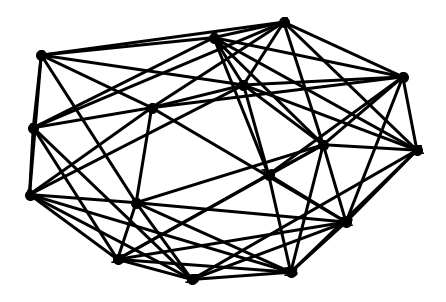

In [74]:
m, b_network = create_barabasi_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(m, b_network.number_of_edges())
plot_distribution(c_network, bins=10, label='Barabasi-Albert graph')
p, e_network = create_erdos_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(p, e_network.number_of_edges())
plot_distribution(e_network, bins=20, label='Erdos graph')
draw_network(e_network)
k, w_network = create_watts_with_nodes_and_edges(PAPER_N_NODES, PAPER_N_EDGES)
print(k, w_network.number_of_edges())
plot_distribution(w_network, bins=20, label='Watts graph')
draw_network(w_network)

In [77]:
bc = calculate_network_centrality(w_network, "betweeness")
pc = calculate_network_centrality(w_network, "pagerank")
dc = calculate_network_centrality(w_network, "degree")


In [80]:
nodes = [i for i in range(PAPER_N_NODES)]

In [78]:
bc

{0: 0.03428571428571429,
 1: 0.03873015873015873,
 2: 0.03603174603174603,
 3: 0.02158730158730159,
 4: 0.03936507936507937,
 5: 0.02555555555555556,
 6: 0.032857142857142856,
 7: 0.04507936507936509,
 8: 0.020000000000000004,
 9: 0.05825396825396825,
 10: 0.021746031746031746,
 11: 0.04031746031746032,
 12: 0.042698412698412694,
 13: 0.02444444444444445,
 14: 0.03111111111111111,
 15: 0.021269841269841272}

In [79]:
pc

{0: 0.06255666873539402,
 1: 0.06292613030784773,
 2: 0.05625023834191997,
 3: 0.05600613733398673,
 4: 0.06263691318198294,
 5: 0.06246901103630385,
 6: 0.06253365457153395,
 7: 0.0691570440513302,
 8: 0.062128906793715175,
 9: 0.07558777349906078,
 10: 0.055396220652986,
 11: 0.06217271700064022,
 12: 0.06912219258292994,
 13: 0.06244513684338763,
 14: 0.0626481062472819,
 15: 0.05596314881969881}

In [93]:
choice = np.random.choice([0, 1])

In [94]:
c = 1 - choice

In [96]:
choice

0

In [82]:
l = sorted(nodes, key= lambda x: pc.get(x))

In [83]:
l

[10, 15, 3, 2, 8, 11, 13, 5, 6, 0, 4, 14, 1, 12, 7, 9]

In [84]:
l = sorted(nodes, key= lambda x: bc.get(x))

In [85]:
l

[8, 15, 3, 10, 13, 5, 14, 6, 0, 2, 1, 4, 11, 12, 7, 9]

In [87]:
l = sorted(nodes, key= lambda x: dc.get(x))

In [88]:
l

[2, 3, 10, 15, 0, 1, 4, 5, 6, 8, 11, 13, 14, 7, 12, 9]

In [89]:
pairs = [sample_pair_through_centrality(w_network, centrality) for _ in range(64)]

In [90]:
pairs

[(3, 4),
 (11, 6),
 (6, 9),
 (14, 2),
 (14, 13),
 (13, 1),
 (2, 4),
 (0, 13),
 (5, 6),
 (12, 13),
 (11, 6),
 (4, 7),
 (15, 14),
 (13, 0),
 (3, 7),
 (3, 2),
 (1, 0),
 (13, 1),
 (5, 6),
 (5, 7),
 (14, 2),
 (1, 7),
 (9, 7),
 (13, 12),
 (8, 6),
 (12, 10),
 (8, 12),
 (2, 5),
 (9, 6),
 (13, 0),
 (2, 1),
 (9, 7),
 (0, 9),
 (13, 10),
 (13, 1),
 (14, 15),
 (13, 12),
 (15, 13),
 (14, 15),
 (4, 8),
 (11, 7),
 (2, 6),
 (11, 5),
 (11, 5),
 (5, 3),
 (3, 2),
 (2, 14),
 (3, 6),
 (10, 13),
 (12, 11),
 (10, 12),
 (13, 12),
 (11, 12),
 (1, 3),
 (8, 10),
 (5, 9),
 (11, 5),
 (15, 0),
 (2, 14),
 (4, 7),
 (12, 13),
 (3, 6),
 (11, 8),
 (9, 7)]

In [55]:
w_network.edges

NameError: name 'w_network' is not defined

In [203]:
g = nx.MultiGraph()
g.add_nodes_from(range(PAPER_N_NODES))
g.add_edges_from(pairs)

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 3,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 3,
 1,
 0,
 2,
 1,
 0,
 0,
 1]

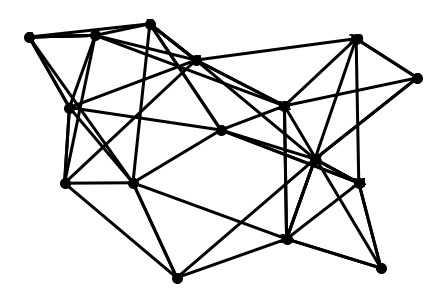

In [204]:
draw_network(g)